In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

In [2]:
from fishchips.experiments import CMB_Primary
from fishchips.cosmo import Observables
import fishchips.cmb_lensing
import fishchips.util

from classy import Class  # CLASS python wrapper
import numpy as np
import matplotlib.pyplot as plt
default_color_list = ['#1A1A1A', '#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#56B4E9']

# Utility Functions for Generating 95%

In [3]:
import corner

def unitize_cov(imp_cov, scales):
    imp_cov = imp_cov.copy()
    npar = imp_cov.shape[0]
    for i in range(npar):
        for j in range(npar):
            imp_cov[i,j] *= scales[i] * scales[j]
    return imp_cov

def get_samps(inp_cov, inp_means, num=int(1e8)):
    samps = np.random.multivariate_normal( np.array(inp_means)/np.sqrt(np.diag(inp_cov)), 
                                           unitize_cov(inp_cov,1./np.sqrt(np.diag(inp_cov))), int(1e7))
    samps = samps[samps.T[-1]>0]
    for i in range(inp_cov.shape[0]):
        samps.T[i] *= np.sqrt(inp_cov[i,i])
        
    return samps

def get_step(mass_input):
    # put in mass in GeV
    return 2e-30 * mass_input**0.15

def get_95_exclusion(input_cov):
    # NOTE: sigma_p MUST BE THE LAST VARIABLE
    samps = get_samps(input_cov, centers, num=int(1e8))
    samps = samps[samps.T[-1]>0]
    onesig, twosig = corner.quantile(samps[:,-1], 
                                 [0.68,0.95], 
                                 weights=1./np.sqrt(samps.T[-1]))
    return twosig

def convert_to_cc(sigma_p_dict, mass_X):
    cc_dict = sigma_p_dict.copy()
    sig = cc_dict['sigma_p']
    mp = 0.9382720813
    GeV = 1./(0.19732705e-15)
    cc_conversion = (1./( (246.22 * GeV)**4 * np.pi)) * \
        ( (mass_X * mp) / (mass_X + mp) * GeV )**2
    derived_cc = np.sqrt( sig / cc_conversion )
    
    # modify dictionary
    cc_dict['cc_dmeff_p'] = derived_cc
    del cc_dict['sigma_p']
    return cc_dict

def convert_to_cc_array(sig, mass_X):
    mp = 0.9382720813
    GeV = 1./(0.19732705e-15)
    cc_conversion = (1./( (246.22 * GeV)**4 * np.pi)) * \
        ( (mass_X * mp) / (mass_X + mp) * GeV )**2
    derived_cc = np.sqrt( sig / cc_conversion )
    return derived_cc

In [4]:
# create an Observables object to store information for derivatives
pars = np.array( ['omega_b', 'omega_dmeff', 'h',  'A_s', 'n_s', 'tau_reio', 'sigma_p'])
centers = np.array([0.02222,  0.1197,  0.69,  2.1955e-9, 0.9655, 0.06, 0.0])
left_steps = np.array([0.0008, 0.003,   0.02,   0.1e-9, 0.01, 0.02, 0.0])
right_steps = np.array([0.0008, 0.003,   0.02,   0.1e-9, 0.01, 0.02, get_step(1.0)])

obs = Observables(parameters=pars,
                  fiducial=centers,
                  left=centers-left_steps,
                  right=centers+right_steps)

# generate a template CLASS python wrapper configuration
classy_template = {'output': 'tCl,pCl,lCl,mPk',
                'l_max_scalars': 5000,
                'lensing': 'yes',
                'omega_cdm':0.,
                'm_dmeff':1,
                'cc_dmeff_op':1,
                'spin_dmeff': 0.5,
                'cc_dmeff_n':0.,
                'use_temperature_dmeff':'yes',
                'use_helium_dmeff':'yes',
                'cc_dmeff_num':1,
                'cc_dmeff_qm2':0,
                'tight_coupling_trigger_tau_c_over_tau_k':0.,
                'tight_coupling_trigger_tau_c_over_tau_h':0.,
              
                 'reionization_optical_depth_tol': 1e-07,
                 'tol_background_integration': 1e-8,
                 'tol_perturb_integration': 1e-8,
                 'tol_thermo_integration': 1e-8,
              
                 'perturb_sampling_stepsize':0.01,
                 'k_max_tau0_over_l_max' : 6}
# classy_template.update(fishchips.util.PRECISE_CLASS_DICT)

# add in the fiducial values too
classy_template.update(dict(zip(obs.parameters, obs.fiducial)))

# Experiments

In [5]:
# SO, 0.4 fsky, goal
import so
SO_tot = so.getSO(2, 2)

/home/zequnl/anaconda3/envs/dm_act/lib/python3.8/site-packages/fishchips-0.0.1-py3.8.egg/fishchips/experiments.py:98: RuntimeWarning: divide by zero encountered in double_scalars
/home/zequnl/anaconda3/envs/dm_act/lib/python3.8/site-packages/fishchips-0.0.1-py3.8.egg/fishchips/experiments.py:99: RuntimeWarning: divide by zero encountered in double_scalars


Generating theory Cls...
Loaded cached Cls from  output/clsAll_low_acc_False_5000_20200827.pkl
Loaded cached Cls from  output/clphi_low_acc_False_5000_20200827.txt


/home/zequnl/anaconda3/envs/dm_act/lib/python3.8/site-packages/fishchips-0.0.1-py3.8.egg/fishchips/cmb_lensing.py:45: RuntimeWarning: overflow encountered in exp
/home/zequnl/anaconda3/envs/dm_act/lib/python3.8/site-packages/orphics/lensing.py:1175: RuntimeWarning: overflow encountered in multiply
  NL = l4 *alval/ 4.
/home/zequnl/anaconda3/envs/dm_act/lib/python3.8/site-packages/orphics/lensing.py:1199: RuntimeWarning: overflow encountered in multiply
  return retval * 2. * np.nan_to_num(1. / lmap/(lmap+1.))
/home/zequnl/anaconda3/envs/dm_act/lib/python3.8/site-packages/orphics/lensing.py:1175: RuntimeWarning: overflow encountered in multiply
  NL = l4 *alval/ 4.
/home/zequnl/anaconda3/envs/dm_act/lib/python3.8/site-packages/orphics/lensing.py:1199: RuntimeWarning: overflow encountered in multiply
  return retval * 2. * np.nan_to_num(1. / lmap/(lmap+1.))
/home/zequnl/anaconda3/envs/dm_act/lib/python3.8/site-packages/orphics/lensing.py:1175: RuntimeWarning: overflow encountered in mult

planck fsky 0.2


In [7]:
SO_tot[1].noise_k

array([1.00000000e+100, 1.00000000e+100, 1.00000000e+100, ...,
       2.90721697e-007, 2.90522566e-007, 2.90323435e-007])

In [ ]:
# CMB-S4
frequencies = np.array([40., 90., 150., 220., 270.])
noise = np.array([5.6, 1.35, 1.81, 9.1, 17.1])
beam = 1.4 * 150 / frequencies

S4 = fishchips.experiments.CMB_Primary(theta_fwhm=beam, sigma_T=noise, sigma_P=noise*1.4, f_sky=0.4, l_min=100, l_max=5000)
S4.noise_T *= 1 + (S4.ells / 3400.0)**(-4.7)
S4.noise_P *= 1 + (S4.ells / 340.0)**(-4.7)
S4.noise_T[S4.ells < 100] = 1e100
S4.noise_T[S4.ells > 3000] = 1e100

S4_lensing = fishchips.cmb_lensing.CMB_Lensing_Only(lens_beam=1.5, lens_f_sky=0.4, lens_noiseT=1.0,
                       lens_noiseP=1.4, lens_pellmax = 4000,lens_kmax = 3000,
                                                NlTT=S4.noise_T, NlEE=S4.noise_P, NlBB=S4.noise_P)

tau_prior = fishchips.experiments.Prior( 'tau_reio', 0.01 )
S4_tot = [S4, S4_lensing, tau_prior] + fishchips.experiments.get_PlanckPol_combine()

Generating theory Cls...
Loaded cached Cls from  output/clsAll_low_acc_False_5000_20181220.pkl
Loaded cached Cls from  output/clphi_low_acc_False_5000_20181220.txt


In [ ]:
# PICO
PICO_FWHM = np.array([38.4,32.0,28.3,23.6,22.2,18.4,12.8,10.7,9.5,7.9,7.4,6.2,4.3,3.6,3.2,2.6,2.5,2.1,1.5,1.3,1.1])
polweight = np.array([16.9,13.0,8.7,5.6,5.6,4.0,3.8,3.0,2.0,1.6,1.5,1.3,2.8,3.2,2.2,3.0,3.2,6.4,32.4,125.3,740.3])
PICO = fishchips.experiments.CMB_Primary(theta_fwhm=PICO_FWHM, sigma_T=polweight / np.sqrt(2.), sigma_P=(polweight), 
                                         f_sky=0.65, l_min=100, l_max=5000)
PICO.noise_T[S4.ells < 100] = 1e100
PICO.noise_T[S4.ells > 3000] = 1e100

PICO_lensing = fishchips.cmb_lensing.CMB_Lensing_Only(lens_beam=6.0, lens_f_sky=0.4, lens_noiseT=0.6,
                           lens_noiseP=0.6*1.4, lens_pellmax = 4000,lens_kmax = 3000,
                                                     NlTT=PICO.noise_T, NlEE=PICO.noise_P, NlBB=PICO.noise_P)

tau_prior = fishchips.experiments.Prior( 'tau_reio', 0.01 )
PICO_tot = [PICO, PICO_lensing, tau_prior] + fishchips.experiments.get_PlanckPol_combine()

Generating theory Cls...
Loaded cached Cls from  output/clsAll_low_acc_False_5000_20181220.pkl
Loaded cached Cls from  output/clphi_low_acc_False_5000_20181220.txt


# Test on 1 GeV

In [ ]:
# generate the fiducial cosmology
obs.compute_cosmo(key='fiducial',
                  classy_dict=convert_to_cc(classy_template,1.0))

# generate an observables dictionary, looping over parameters
for par, par_left, par_right in zip(obs.parameters, obs.left, obs.right):
    classy_left = classy_template.copy()
    classy_left[par] = par_left
    classy_right = classy_template.copy()
    classy_right[par] = par_right
    # pass the dictionaries full of configurations to get computed
    obs.compute_cosmo(key=par + '_left',
                      classy_dict=convert_to_cc(classy_left, 1.0))
    obs.compute_cosmo(key=par + '_right',
                      classy_dict=convert_to_cc(classy_right, 1.0))

In [ ]:
fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=False) for exp in [S4, S4_lensing]], axis=0 )
cov = np.linalg.inv(fisher)
get_95_exclusion(cov) * 1e4

6.679749422429351e-27

In [ ]:
fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=False) for exp in SO_tot], axis=0 )
cov = np.linalg.inv(fisher)
get_95_exclusion(cov) * 1e4

2.0590468875123608e-26

In [ ]:
fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=False) for exp in PICO_tot], axis=0 )
cov = np.linalg.inv(fisher)
get_95_exclusion(cov) * 1e4

6.811340777335297e-27

Recall for SO,
```
goal, 1 GeV, fsky=0.4 : 2.05278063e-26
goal, 1 MeV, fsky=0.4 : 4.43100897e-27
```

# Compute Curves

In [ ]:
def get_obs_from_mass(mass_GeV):
    # create an Observables object to store information for derivatives
    left_steps = np.array([0.0008, 0.003,   0.02,   0.1e-9, 0.01, 0.02, 0.0])
    right_steps = np.array([0.0008, 0.003,   0.02,   0.1e-9, 0.01, 0.02, get_step(mass_GeV)])

    obs = Observables(parameters=pars,
                      fiducial=centers,
                      left=centers-left_steps,
                      right=centers+right_steps)

    # generate a template CLASS python wrapper configuration
    classy_template = {'output': 'tCl,pCl,lCl,mPk',
                    'l_max_scalars': 5000,
                    'lensing': 'yes',
                    'omega_cdm':0.,
                    'm_dmeff': mass_GeV,
                    'cc_dmeff_op':1,
                    'spin_dmeff': 0.5,
                    'cc_dmeff_n':0.,
                    'use_temperature_dmeff':'yes',
                    'use_helium_dmeff':'yes',
                    'cc_dmeff_num':1,
                    'cc_dmeff_qm2':0,
                    'tight_coupling_trigger_tau_c_over_tau_k':0.,
                    'tight_coupling_trigger_tau_c_over_tau_h':0.,

                     'reionization_optical_depth_tol': 1e-07,
                     'tol_background_integration': 1e-8,
                     'tol_perturb_integration': 1e-8,
                     'tol_thermo_integration': 1e-8,

                     'perturb_sampling_stepsize':0.01,
                     'k_max_tau0_over_l_max' : 6}
    classy_template.update(fishchips.util.PRECISE_CLASS_DICT)

    # add in the fiducial values too
    classy_template.update(dict(zip(obs.parameters, obs.fiducial)))
    
    
    # generate the fiducial cosmology
    obs.compute_cosmo(key='fiducial',
                      classy_dict=convert_to_cc(classy_template,mass_GeV))

    # generate an observables dictionary, looping over parameters
    for par, par_left, par_right in zip(obs.parameters, obs.left, obs.right):
        classy_left = classy_template.copy()
        classy_left[par] = par_left
        classy_right = classy_template.copy()
        classy_right[par] = par_right
        # pass the dictionaries full of configurations to get computed
        obs.compute_cosmo(key=par + '_left',
                          classy_dict=convert_to_cc(classy_left, mass_GeV))
        obs.compute_cosmo(key=par + '_right',
                          classy_dict=convert_to_cc(classy_right, mass_GeV))
        

    return obs
    
#     obs.clean_cosmo()
#     return get_95_exclusion(cov) * 1e4

In [ ]:
num_masses = 20 # number of grid points
input_masses = 10**np.linspace(np.log10(15e-6),3,num_masses) # from 15 keV to 1 TeV

PICO_cons = []
SO_cons = []
S4_cons = []

for m in input_masses:
    obs = get_obs_from_mass(m)
    
    # PICO
    fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=False) for exp in PICO_tot], axis=0 )
    cov = np.linalg.inv(fisher)
    PICO_cons.append(get_95_exclusion(cov) * 1e4)
    
    # SO
    fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=False) for exp in SO_tot], axis=0 )
    cov = np.linalg.inv(fisher)
    SO_cons.append(get_95_exclusion(cov) * 1e4)
    
    
    # S4
    fisher = np.sum( [exp.get_fisher(obs, lensed_Cl=False) for exp in S4_tot], axis=0 )
    cov = np.linalg.inv(fisher)
    S4_cons.append(get_95_exclusion(cov) * 1e4)
    
    obs.clean_cosmo()

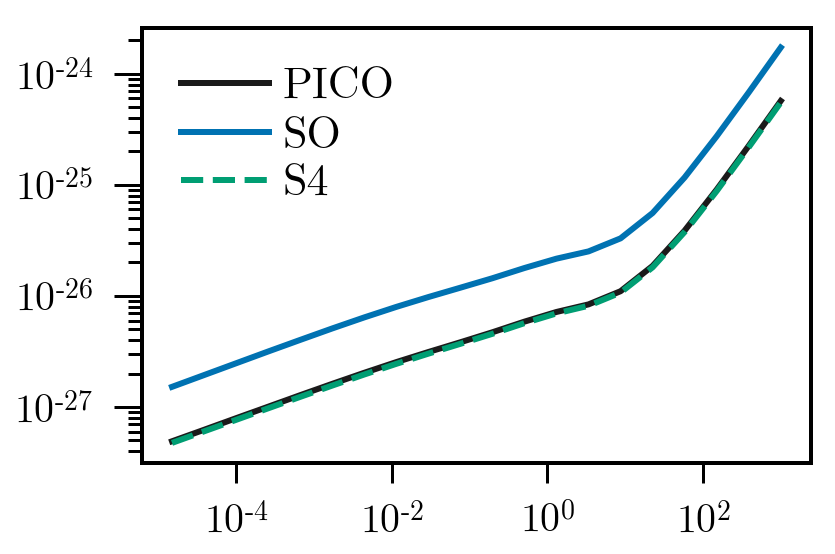

In [21]:
plt.plot( input_masses, PICO_cons, label="PICO" )
plt.plot( input_masses, SO_cons, label="SO" )
plt.plot( input_masses, S4_cons, label="S4", ls="--" )
plt.yscale("log")
plt.xscale("log")

plt.legend()

In [22]:
from astropy.io import ascii

ascii.write([input_masses, 
             PICO_cons], 
            'PICO_forecast.dat', 
            names=['mass(GeV)', 'PICO(cm^2)'], overwrite=True)


ascii.write([input_masses, 
             SO_cons], 
            'SO_forecast.dat', 
            names=['mass(GeV)', 'SO(cm^2)'], overwrite=True)


ascii.write([input_masses, 
             S4_cons], 
            'S4_forecast.dat', 
            names=['mass(GeV)', 'S4(cm^2)'], overwrite=True)

In [23]:
np.array(PICO_cons) / np.array(SO_cons)

array([0.32358032, 0.32158753, 0.32028374, 0.31831968, 0.31795327,
       0.3170874 , 0.31725034, 0.31843531, 0.32000009, 0.32262797,
       0.32625528, 0.32902453, 0.33114926, 0.33344156, 0.33435335,
       0.33396575, 0.33222694, 0.3309598 , 0.33068655, 0.33050239])

In [24]:
np.array(PICO_cons) / np.array(S4_cons)

array([1.03383236, 1.03266409, 1.03467056, 1.03405991, 1.03580121,
       1.03619406, 1.03617498, 1.03652222, 1.03469521, 1.03276439,
       1.03243416, 1.03160747, 1.03023389, 1.02920192, 1.02861186,
       1.02948888, 1.02849566, 1.03034724, 1.03023098, 1.0314273 ])